In [39]:
%matplotlib inline

# Module 9 Lab - Model Evaluation

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [40]:
import numpy as np
import random as py_random
from math import sin
import numpy.random as np_random
import time
import matplotlib.pyplot as plt
import random as py_random
from __future__ import division
import patsy
import pandas as pd
import sklearn.linear_model as linear
import scipy.stats as stats
from sklearn.cross_validation import KFold

# Resample WITH replacement
def resample(data):
    n = len(data)
    return [data[i] for i in [py_random.randint(0, n - 1) for _ in xrange(0, n)]]

def bootstrap_error(generalization_error):
    return np.array([np.mean(sample) for sample in [resample(generalization_error) for i in xrange(0, 10000)]])

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We already are doing Bootstrap sampling to evaluate our Linear and Logistic Regressions, this is just as good as cross validation. For other models, we might need cross validation so we'll still need a little practice.

After that we're going to concentrate a bit more Model Improvement in this Lab.

**1\. Pick a Linear Regression model from the Module 7 Lab that you thought was particularly good at *prediction*.** Mean Squared Error (MSE) is the generally accepted performance metric for regression problems. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the MSE. Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Calculate the MSE for the true model. How well did you do?

In [41]:
# Create data
np_random.seed(314)
py_random.seed(314)
x_1 = np_random.uniform(100,200,1000)
noise = np.random.normal(0, 5.0, 1000)
y = 32.5 + (2.3 * x_1) + noise
instances = np.column_stack((x_1, noise, y))

# Run 3 rounds of 10-fold cross validation
generalization_error = []
for rd in [1, 2, 3]:
    np.random.shuffle(instances)
    kf = KFold(1000, n_folds=10)
    for train, test in kf:
        # Learn linear regression model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train, :-1], instances[train, -1])
        # Predict
        predictions = model.predict(instances[test, :-1])
        # Calculate MSE
        mse = np.mean((predictions - instances[test, -1]) ** 2)
        generalization_error.append(mse)
        
# Calculate the 90% credible interval
resampled_means_mse = bootstrap_error(generalization_error)
print "90% CI", stats.mstats.mquantiles(resampled_means_mse, [0.05, 0.95])

# Calcuate the MSE for the true model
true_predictions = 32.5 + (2.3 * instances[:, 0])
print "True model MSE: %f" % np.mean((true_predictions - instances[:, -1]) ** 2)

90% CI [ 36.21666325  38.40218092]
True model MSE: 25.409757


I chose this particular model due to its high r-squared and low sigma values from the original lab.

My bootstrap estimate is within 37% of the true model's MSE.

**2\. Pick a Logistic Regression model from the Module 8 Lab that you thought was particularly good at *prediction*.** Although there are different metrics you can use for classification, because this data was made up, let's concentrate on error rate. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the error rate.  Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Calculate the MSE for the true model. How well did you do?

In [42]:
# Actual data
py_random.seed(3140)
np_random.seed(3140)
x_1 = np.random.normal(0, 1, 1000)
x_2 = np.random.standard_normal(1000)
z = 1 + 2 * x_1 + 3 * x_2
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
instances = np.column_stack((x_1, x_2, y))

# Run 3 rounds of 10-fold cross validation
generalization_error = []
for rd in [1, 2, 3]:
    np.random.shuffle(instances)
    kf = KFold(1000, n_folds=10)
    for train, test in kf:
        # Learn linear regression model
        model = linear.LogisticRegression(fit_intercept=False).fit(instances[train, :-1], instances[train, -1])
        # Predict
        predictions = model.predict(instances[test, :-1])
        # Calculate misclassification rate
        error = 1 - (sum(predictions == instances[test, -1]) / len(predictions))
        generalization_error.append(error)
        
# Calculate the 90% credible interval
resampled_error = bootstrap_error(generalization_error)
print "90% CI", stats.mstats.mquantiles(resampled_error, [0.05, 0.95])

# Calcuate the misclassification rate for the true model
z = 1 + 2 * instances[:, 0] + 3 * instances[:, 1]
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
print "True misclassification rate: %f" % (1 - (sum(y == instances[:, -1]) / instances.shape[0]))

90% CI [ 0.14866667  0.16833333]
True misclassification rate: 0.189000


My bootstrap estimate for the misclassification rate is within 4% of the true model's error.

## Model Improvement

As was discussed in the Lecture, our main method of evaluating whether a model can be improved is through the bias/variance tradeoff. This tradeoff can be evaluated in one of two ways: Learning Curves and Validation Curves.

*Learning Curves* concentrate on the perennial question: will getting more data improve this model?

*Validation Curves* concentrate on a related question: can more variables, regularization, and or transformations improve this model?

Note that these questions are always asked in a predictive sense, looking at the performance metric and its generalization to unseen data (test set). So, if we're to be good practitioners when working with real data, we want to *see* these things happen in controlled circumstances.

### Learning Curves

**1\. Basic Learning Curve.**

Create data for a Linear Regression model as we've done in previous Modules. You should have 3 to 5 variables but it doesn't have to be fancy or tricky. Generate 1000 observations. Plot Learning Curves for the Linear Regression using averaging over 10 fold cross validation. Make a special note of the $\epsilon$ you pick.

Do the Learning Curves indicate that getting more data would improve the model's predictive accuracy? If they do not, generate more data until they indicate you have enough data. How much did you need?

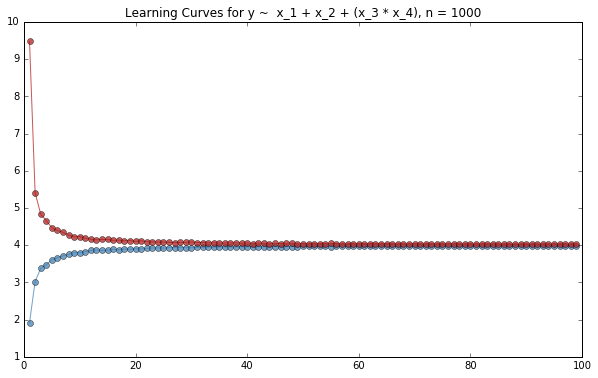

In [43]:
# Create data
np_random.seed(31400)
py_random.seed(31400)
x_1 = np_random.normal(0,13,1000)
x_2 = np_random.normal(0,2,1000)
x_3 = np_random.normal(0,45,1000)
x_4 = np_random.normal(0,1,1000)
noise = np.random.normal(0, 10, 1000)
y = 2.0 + 23 * x_1 + 90 * x_2 + 34 * (x_3 * x_4) + noise
instances = np.column_stack((x_1, x_2, x_3 * x_4, noise, y))

train_mean_mse = []
test_mean_mse = []
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(1, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = np.mean((train_predictions - instances[train_indices, -1]) ** 2)
        test_mse = np.mean((test_predictions - instances[test_indices, -1]) ** 2)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(1,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(1,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves for y ~  x_1 + x_2 + (x_3 * x_4), n = 1000")

It appears the training error and testing error converge at about an MSE ~4.00 when I use about 55% of the data, or 550 samples.

**2\. Increase your $\epsilon$, regenerate the data and re-plot the Learning Curves. Do this several times. Does increasing $\epsilon$ change the convergence of the Learning Curves or the absolute error at convergence?**

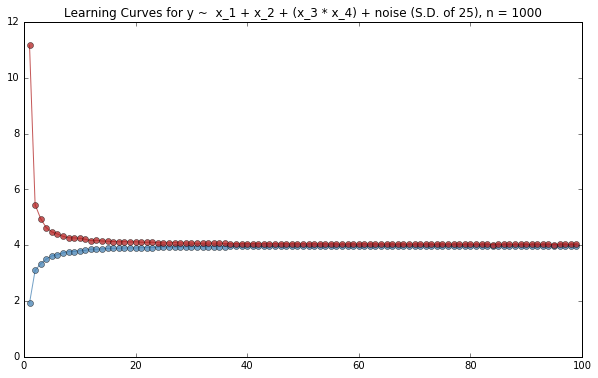

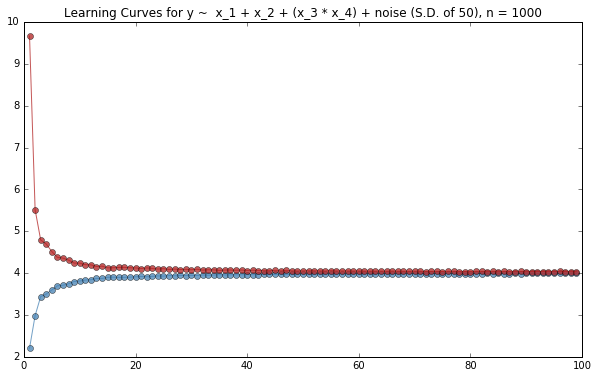

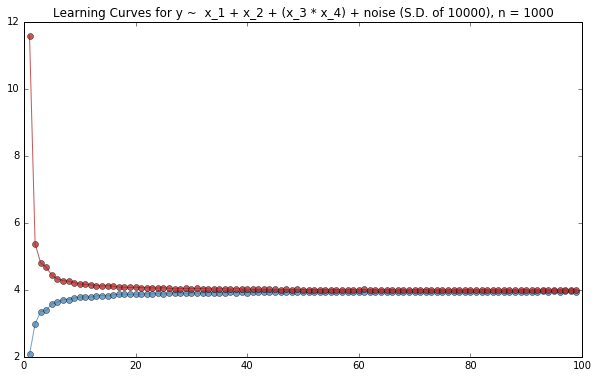

In [44]:
# Create data
np_random.seed(3140000)
py_random.seed(3140000)
x_1 = np_random.normal(0,13,1000)
x_2 = np_random.normal(0,2,1000)
x_3 = np_random.normal(0,45,1000)
x_4 = np_random.normal(0,1,1000)
noise = np.random.normal(0, 25, 1000)
y = 2.0 + 23 * x_1 + 90 * x_2 + 34 * (x_3 * x_4) + noise
instances = np.column_stack((x_1, x_2, x_3 * x_4, noise, y))

train_mean_mse = []
test_mean_mse = []
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(1, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = np.mean((train_predictions - instances[train_indices, -1]) ** 2)
        test_mse = np.mean((test_predictions - instances[test_indices, -1]) ** 2)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(1,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(1,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves for y ~  x_1 + x_2 + (x_3 * x_4) + noise (S.D. of 25), n = 1000")

# Create data
x_1 = np_random.normal(0,13,1000)
x_2 = np_random.normal(0,2,1000)
x_3 = np_random.normal(0,45,1000)
x_4 = np_random.normal(0,1,1000)
noise = np.random.normal(0, 50, 1000)
y = 2.0 + 23 * x_1 + 90 * x_2 + 34 * (x_3 * x_4) + noise
instances = np.column_stack((x_1, x_2, x_3 * x_4, noise, y))

train_mean_mse = []
test_mean_mse = []
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(1, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = np.mean((train_predictions - instances[train_indices, -1]) ** 2)
        test_mse = np.mean((test_predictions - instances[test_indices, -1]) ** 2)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(1,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(1,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves for y ~  x_1 + x_2 + (x_3 * x_4) + noise (S.D. of 50), n = 1000")

# Create data
x_1 = np_random.normal(0,13,1000)
x_2 = np_random.normal(0,2,1000)
x_3 = np_random.normal(0,45,1000)
x_4 = np_random.normal(0,1,1000)
noise = np.random.normal(0, 10000, 1000)
y = 2.0 + 23 * x_1 + 90 * x_2 + 34 * (x_3 * x_4) + noise
instances = np.column_stack((x_1, x_2, x_3 * x_4, noise, y))

train_mean_mse = []
test_mean_mse = []
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(1, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = np.mean((train_predictions - instances[train_indices, -1]) ** 2)
        test_mse = np.mean((test_predictions - instances[test_indices, -1]) ** 2)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(1,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(1,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves for y ~  x_1 + x_2 + (x_3 * x_4) + noise (S.D. of 10000), n = 1000")

Increasing the noise didn't have the expect I was anticipating, namely that increasing the noise would increase the value of MSE that the curves converge on. This value is still ~4.00 MSE as before. What I did expect was the amount of data that would be needed to converge. In the case of the noise being increased to 25, convergence happened *earlier* at ~40%. In the case of increasing the noise to 50 or 1000, the convergence happened at ~90% and ~60%. Although I did expect the amount of data needed for convergence to change, I thought it would be linearly dependent on how much the S.D. of the noise changed but I saw a non-linear relationship between the S.D. of the noise and the convergence point. This may be caused by the large coefficients I used for generating the original data. These large coefficients may have dwarfed any effect the noise was having.

**3\. Go back to your original $\epsilon$ and instead remove all your variables but one ($X_1$, for example). Now what happens to your Learning Curves? Do they still converge at a higher error rate or do they no longer converge?**

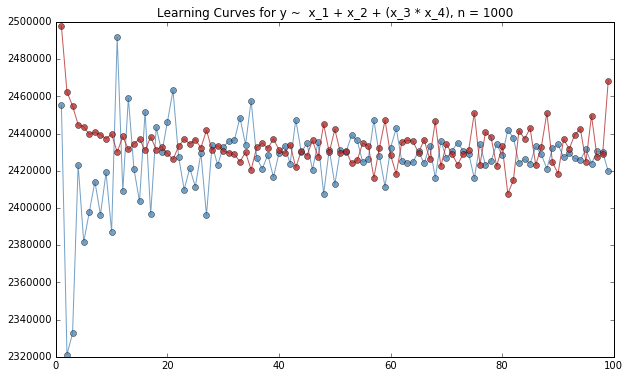

In [47]:
# Create data
np_random.seed(31400)
py_random.seed(31400)
x_1 = np_random.normal(0,13,10000)
x_2 = np_random.normal(0,2,10000)
x_3 = np_random.normal(0,45,10000)
x_4 = np_random.normal(0,1,10000)
noise = np.random.normal(0, 10, 10000)
y = 2.0 + 23 * x_1 + 90 * x_2 + 34 * (x_3 * x_4) + noise
instances = np.column_stack((x_1, noise, y))

train_mean_mse = []
test_mean_mse = []
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(1, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LinearRegression(fit_intercept=False).fit(instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = np.mean((train_predictions - instances[train_indices, -1]) ** 2)
        test_mse = np.mean((test_predictions - instances[test_indices, -1]) ** 2)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(1,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(1,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves for y ~  x_1 + x_2 + (x_3 * x_4), n = 1000")

Initially, I used 1000 samples like the original problem but convergence no longer happened so I increased the number of samples to 10,000 and convergence still didn't happen. In addition, the MSE that the curves slightly converged to was ~2,430,000, which is much higher than the original MSE of 4.

## Validation Curves

**1\. Basic Validation Curve.**

This one should be pretty straight forward because we've been working with the canonical example. For these experiments, especially, it is probably best to be working with mean centered data. You can simply generate it that way. This will allow you to interpret the $beta$s more as weights/contributions than just scaling factors.

Create data for a Linear Regression model as we've done in previous Modules.  You should have 5 variables (inputs) but only 3 actual $X_i$. Using $D_i$ to indicate actual data, then $X_1 = D_1^1$, $X_2=D_1^n$, $X_3=D_1^{m}$ and $X_4=D_2$ and $X_5=D_3$.

$n$ and $m$ are to control different degrees of the polynomial and $m>n$. Really, you just want something like $D_1^1$, $D_1^2$, $D_1^5$, $D_2$, $D_3$ as your $X_1$, $X_2$, $X_3$, $X_4$, $X_5$.

Basically, you want to do validation curves for all your inputs starting with $X_1$, $X_4$, $X_5$ and then see if they indicate if $X_2$ and or $X_3$ are missing. What happens when the $beta$ is bigger on $X_1$ or the $beta$ is bigger on $X_4$? Does that make a difference? You should experiment with many variations.

[60629891.958328828, 71819028.243284464, 27670339.539289702, 71015980.400665566, 1121.5210368556711]
[57931996.39884042, 73191229.178941339, 27622252.56732009, 77246924.429056063, 1150.0317370486318]


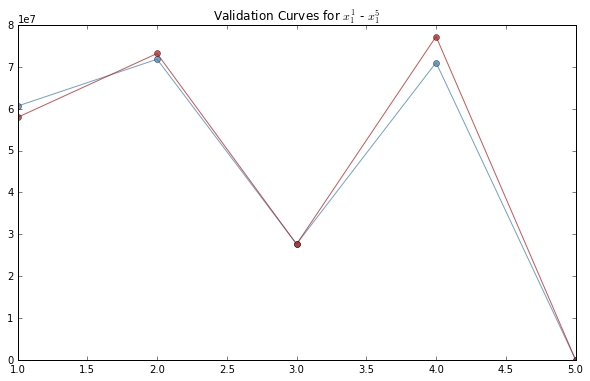

In [48]:
def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

from copy import deepcopy

def cross_validate( formula, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    py_random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse

def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print train
    print test
    return train, test

# Create data
np_random.seed(310)
py_random.seed(310)
data = pd.DataFrame()
x_1 = np.random.normal(0, 14, 1000)
data["x1"] = x_1
x_2 = np.random.uniform(0, 1, 1000)
data["x2"] = x_2
x_3 = np.random.normal(0, 20, 1000)
data["x3"] = x_3
data["x_1"] = data["x1"]
data["x_1_2"] = data["x1"] ** 2
data["x_1_3"] = data["x1"] ** 3
data["x_1_4"] = data["x1"] ** 4
data["x_1_5"] = data["x1"] ** 5
data["x_4"] = data["x2"]
data["x_5"] = data["x3"]
y = 2.0 + x_1 + 4.2 * (x_1 ** 2) + 5.6 * (x_1 ** 5) + x_2 + 6.9 * x_3
data["y"] = y
xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x_1 + x_4 + x_5",
                                 "y ~ x_1_2 + x_4 + x_5",
                                 "y ~ x_1_3 + x_4 + x_5",
                                 "y ~ x_1_4 + x_4 + x_5",
                                 "y ~ x_1_5 + x_4 + x_5"
                                ], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x_1^1$ - $x_1^5$")

These validation curves test the degree on the x_1 term of the model. It shows that for a degree of 5, MSE is minimized, meaning that x_1 ^ 5 belongs in the model. We can rerun the validation curve test with this polynomial included now and testing if adding another x_1 term is helpful:

[1113.6681876064681, 11.693713743463473, 1113.5704823331371, 502.26598071432869, 1125.9140238963437]
[1183.0674945795552, 11.832092558932686, 1186.3190507565005, 521.98233639259809, 1130.971357711727]


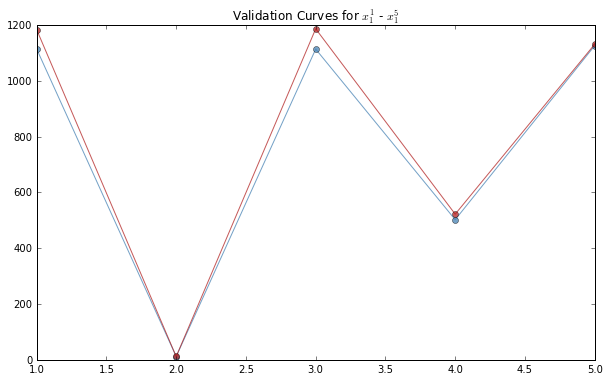

In [49]:
train, test = validation_curves(["y ~ x_1 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_2 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_3 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_4 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_5 + x_1_5 + x_4 + x_5"
                                ], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x_1^1$ - $x_1^5$")

Here we see that x_1 ^ 2 + x_1 ^ 5 + x_4 + x_5 minimizes the MSE. These validation curves come from varying the degree of x_1 in the formula x_1 ^ n + x_1 ^ 5 + x_4 + x_5. This means that our model is improved if we are forced to include an additional x_1 then x_1 ^ 2 should be it. If we still have a hunch about x_1's influence, we could replot the validation curves with the updated formula x_1 ^ 2 + x_1 ^ 5 + x_4 + x_5 to get:

[5.0663702156097982e-08, 11.698615272819611, 5.8049941618150172, 11.689606322380575, 11.679458518200198]
[4.9244235661029256e-08, 11.842093455937508, 6.0177559951692192, 11.926363159239372, 11.894404763076862]


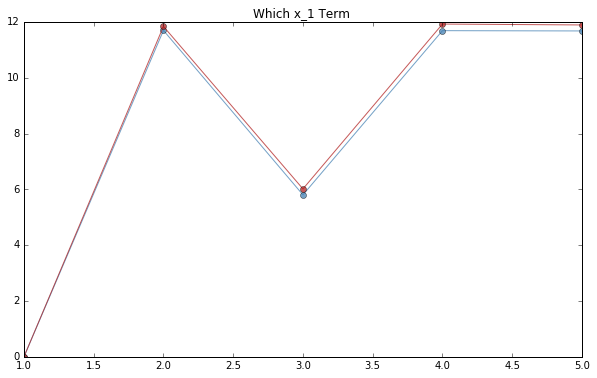

In [50]:
train, test = validation_curves(["y ~ x_1 + x_1_2 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_2 + x_1_2 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_3 + x_1_2 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_4 + x_1_2 + x_1_5 + x_4 + x_5",
                                 "y ~ x_1_5 + x_1_2 + x_1_5 + x_4 + x_5"
                                ], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
xs = [1, 2, 3, 4, 5]
axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Which x_1 Term ")

Here we see that it looks like the x_1 term belongs in the formula giving us y ~ x_1 + x_1 ^ 2 + x_1 ^ 5 + x_4 + x_5.

Now let's start from the begin and mess with the betas for x_4 and x_5. First let's increase the beta for x_4 so that is is larger than any other beta:

[68428687.379798084, 76299066.821824372, 32523111.119285513, 75044249.851169407, 269.32120775740788]
[60378662.284146659, 85429816.814343259, 32982740.265940327, 78568832.436643705, 275.13648397945553]


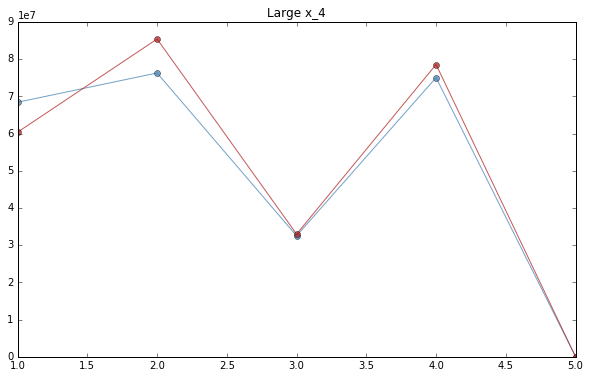

In [51]:
data = pd.DataFrame()
x_1 = np.random.normal(0, 14, 1000)
data["x1"] = x_1
x_2 = np.random.uniform(0, 1, 1000)
data["x2"] = x_2
x_3 = np.random.normal(0, 20, 1000)
data["x3"] = x_3
data["x_1"] = data["x1"]
data["x_1_2"] = data["x1"] ** 2
data["x_1_3"] = data["x1"] ** 3
data["x_1_4"] = data["x1"] ** 4
data["x_1_5"] = data["x1"] ** 5
data["x_4"] = data["x2"]
data["x_5"] = data["x3"]**5
y = 2.0 + x_1 + (x_1 ** 2) + 5.6 * (x_1 ** 5) + 14 * x_2 + x_3
data["y"] = y
xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x_1 + x_4 + x_5",
                                 "y ~ x_1_2 + x_4 + x_5",
                                 "y ~ x_1_3 + x_4 + x_5",
                                 "y ~ x_1_4 + x_4 + x_5",
                                 "y ~ x_1_5 + x_4 + x_5"
                                ], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Large x_4")

These are nearly identical results as those from the first experiment. I want to try again with a huge coefficient on x_4:

[51155229.917591989, 61814995.258024186, 24021571.798627235, 59442372.360108368, 250.83730323228778]
[49877287.138450868, 59085974.930732049, 24140772.623655796, 64614972.264584973, 256.45966766207704]


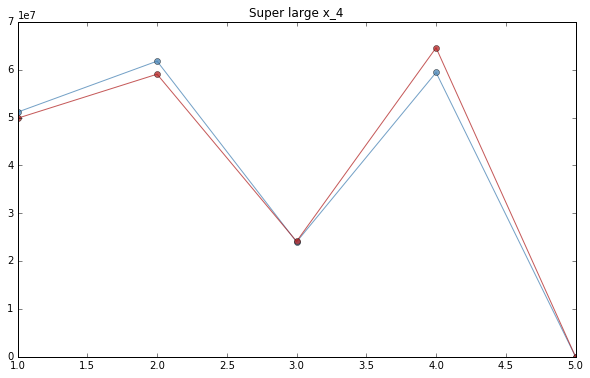

In [52]:
data = pd.DataFrame()
x_1 = np.random.normal(0, 14, 1000)
data["x1"] = x_1
x_2 = np.random.uniform(0, 1, 1000)
data["x2"] = x_2
x_3 = np.random.normal(0, 20, 1000)
data["x3"] = x_3
data["x_1"] = data["x1"]
data["x_1_2"] = data["x1"] ** 2
data["x_1_3"] = data["x1"] ** 3
data["x_1_4"] = data["x1"] ** 4
data["x_1_5"] = data["x1"] ** 5
data["x_4"] = data["x2"]
data["x_5"] = data["x3"]**5
y = 2.0 + x_1 + (x_1 ** 2) + 5.6 * (x_1 ** 5) + 14000 * x_2 + x_3
data["y"] = y
xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x_1 + x_4 + x_5",
                                 "y ~ x_1_2 + x_4 + x_5",
                                 "y ~ x_1_3 + x_4 + x_5",
                                 "y ~ x_1_4 + x_4 + x_5",
                                 "y ~ x_1_5 + x_4 + x_5"
                                ], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Super large x_4")

Again, these are identical results. I think it is safe to say coefficient changes don't affect the validation curves.